In [67]:
import rasterio
import matplotlib.pyplot as plt
import os
import typing as T
from pathlib import Path

import cv2
import tifffile as tiff
import numpy as np

In [68]:
def scale_band(band, percentile: float = 95) -> np.ndarray:
    return band / np.percentile(band, percentile)

In [69]:
# Read filenames from a directory
directory = '../prepared_dataset/image_directory_20180514_9'
filenames = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.tif')]

bands_dict = {}
for filename in filenames:
    bands_name = filename.split('/')[-1].split('.')[0]
    if bands_name != 'B11' or bands_name != 'B12':
        bands_dict[bands_name] = scale_band(
            tiff.imread(filename),
            percentile=95
        )
    else:
        band_resize = cv2.resize(
            tiff.imread(filename),
            None,
            fx = 2,
            fy = 2,
            interpolation = cv2.INTER_CUBIC
        )
        bands_dict[bands_name] = scale_band(
            band_resize,
            percentile=95
        )

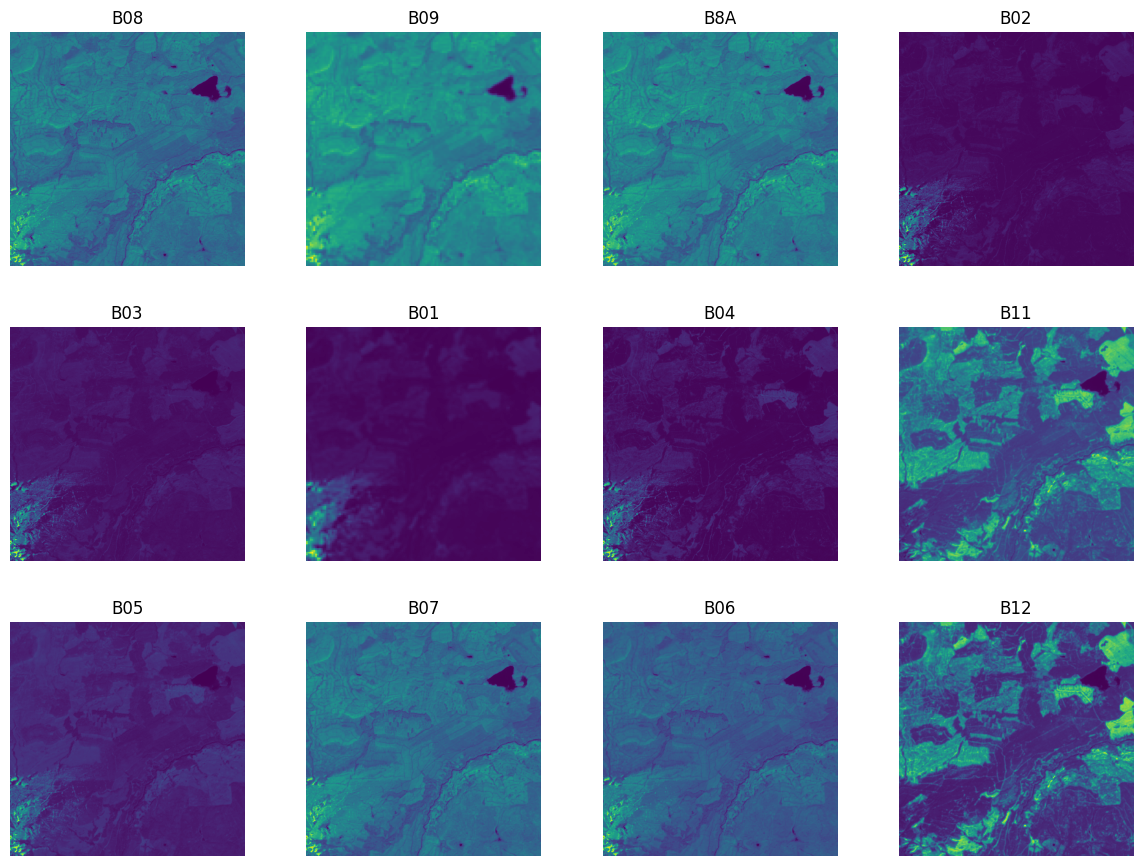

In [71]:
num_bands = len(bands_dict)
num_rows = int(np.ceil(num_bands / 4.0))
fig, axes = plt.subplots(num_rows, 4, figsize=(12, 3 * num_rows))
fig.tight_layout()

# Save the images
save_dir = Path('../dataset_tables/bands')
save_dir.mkdir(parents=True, exist_ok=True)

for i, (title, image) in enumerate(bands_dict.items()):
    row = i // 4
    col = i % 4
    if num_rows == 1:  # If there's only one row, axes is a 1D array
        ax = axes[col]
    else:
        ax = axes[row, col]

    # Adjust colormap and normalization for NBR
    ax.imshow(image)

    ax.set_title(title)
    ax.axis("off")

    # image = (image * 255).astype(np.uint8)
    plt.imsave(str(save_dir / f'{title}.png'), image)

plt.show()

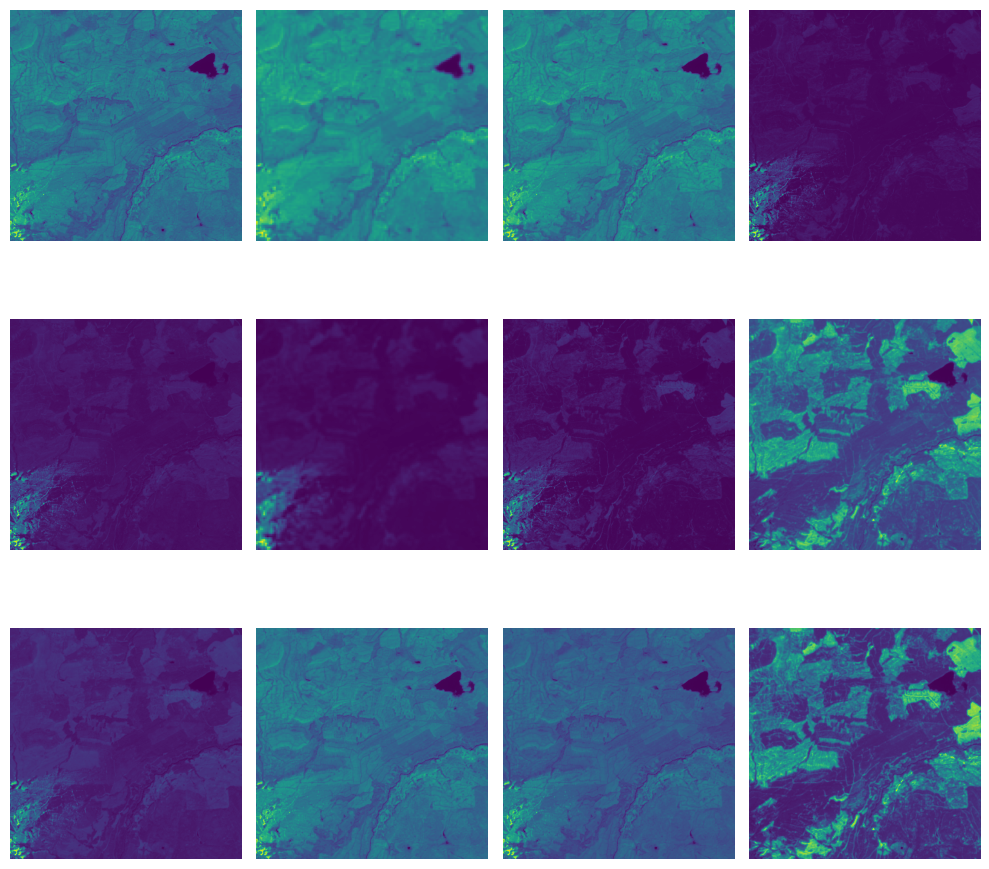

In [25]:
num_bands = len(filenames)
# Calculate the number of rows based on the number of images
num_rows = int(np.ceil(num_bands / 3.0))
fig, axes = plt.subplots(num_rows, 3, figsize=(12, 4 * num_rows))
fig.tight_layout()

for i, (title, image) in enumerate(image_dict.items()):
    row = i // 3
    col = i % 3
    if num_rows == 1:  # If there's only one row, axes is a 1D array
        ax = axes[col]
    else:
        ax = axes[row, col]

    # Adjust colormap and normalization for NBR
    if title == "NBR":
        im = ax.imshow(image, cmap=plt.cm.RdYlGn, vmin=-1, vmax=1)
        plt.colorbar(im, ax=ax, orientation='vertical')
    else:
        ax.imshow(image)

    ax.set_title(title)
    ax.axis("off")

plt.show()

In [65]:
def display_images(images: T.Dict[str, np.ndarray]):
    num_images = len(images)
    # Calculate the number of rows based on the number of images
    num_rows = int(np.ceil(num_images / 3.0))
    fig, axes = plt.subplots(num_rows, 3, figsize=(12, 4 * num_rows))
    fig.tight_layout()

    for i, (title, image) in enumerate(images.items()):
        row = i // 3
        col = i % 3
        if num_rows == 1:  # If there's only one row, axes is a 1D array
            ax = axes[col]
        else:
            ax = axes[row, col]

        # Adjust colormap and normalization for NBR
        if title == "NBR":
            im = ax.imshow(image, cmap=plt.cm.RdYlGn, vmin=-1, vmax=1)
            plt.colorbar(im, ax=ax, orientation='vertical')
        else:
            ax.imshow(image)

        ax.set_title(title)
        ax.axis("off")

    plt.show()

def display_transformed_images(filepath, percentile: int = 95):

    B02 = scale_band(
        tiff.imread(filepath + '/B02.tif'),
        percentile=percentile
    )
    B03 = scale_band(
        tiff.imread(filepath + '/B03.tif'),
        percentile=percentile
    )
    B04 = scale_band(
        tiff.imread(filepath + '/B04.tif'),
        percentile=percentile
    )
    B07 = scale_band(
        tiff.imread(filepath + '/B07.tif'),
        percentile=percentile
    )
    B08 = scale_band(
        tiff.imread(filepath + '/B08.tif'),
        percentile=percentile
    )
    B11 = cv2.resize(
        tiff.imread(filepath + '/B11.tif'),
        None,
        fx=2,
        fy=2,
        interpolation=cv2.INTER_CUBIC
    )
    B12 = cv2.resize(
        tiff.imread(filepath + '/B12.tif'),
        None,
        fx=2,
        fy=2,
        interpolation=cv2.INTER_CUBIC
    )
    B11 = scale_band(B11, percentile=percentile)
    B12 = scale_band(B12, percentile=percentile)

    # Calculate NDVI (Normalized Difference Vegetation Index)
    NDVI = (B08 - B04) / (B08 + B04)

    # Calculate NDBI (Normalized Difference Built-Up Index)
    NDBI = (B11 - B08) / (B11 + B08)

    # Calculate NDWI (Normalized Difference Water Index)
    NDWI = (B08 - B12) / (B08 + B12)

    # Create a color image using RGB bands
    RGB = np.stack([B04, B03, B02], axis=-1)

    # Upscale B07 to match the resolution of B04
    B07_rescaled = cv2.resize(
        B07, (B04.shape[1], B04.shape[0]), interpolation=cv2.INTER_CUBIC)

    # Now compute NBR
    NBR = (B08 - B07_rescaled) / (B08 + B07_rescaled)
    # Create a false-color composite image
    false_color = np.stack([B08, B04, B03], axis=-1)

    output = {
        "NBR": NBR,
        "NDVI": NDVI,
        "NDBI": NDBI,
        "NDWI": NDWI,
        "RGB": RGB,
        "False Color": false_color
    }

    display_images(
        {
            "NBR": NBR,
            "NDVI": NDVI,
            "NDBI": NDBI,
            "NDWI": NDWI,
            "RGB": RGB,
            "False Color": false_color
        }
    )

def save_transformed_images(filepath, percentile: int = 95):
    '''
    Save the transformed images as png files
    '''

    B02 = scale_band(
        tiff.imread(filepath + '/B02.tif'),
        percentile=percentile
    )
    B03 = scale_band(
        tiff.imread(filepath + '/B03.tif'),
        percentile=percentile
    )
    B04 = scale_band(
        tiff.imread(filepath + '/B04.tif'),
        percentile=percentile
    )
    B07 = scale_band(
        tiff.imread(filepath + '/B07.tif'),
        percentile=percentile
    )
    B08 = scale_band(
        tiff.imread(filepath + '/B08.tif'),
        percentile=percentile
    )
    B11 = cv2.resize(
        tiff.imread(filepath + '/B11.tif'),
        None,
        fx=2,
        fy=2,
        interpolation=cv2.INTER_CUBIC
    )
    B12 = cv2.resize(
        tiff.imread(filepath + '/B12.tif'),
        None,
        fx=2,
        fy=2,
        interpolation=cv2.INTER_CUBIC
    )
    B11 = scale_band(B11, percentile=percentile)
    B12 = scale_band(B12, percentile=percentile)

    # Calculate NDVI (Normalized Difference Vegetation Index)
    NDVI = (B08 - B04) / (B08 + B04)

    # Calculate NDBI (Normalized Difference Built-Up Index)
    NDBI = (B11 - B08) / (B11 + B08)

    # Calculate NDWI (Normalized Difference Water Index)
    NDWI = (B08 - B12) / (B08 + B12)

    # Create a color image using RGB bands
    RGB = np.stack([B04, B03, B02], axis=-1)

    # Upscale B07 to match the resolution of B04
    B07_rescaled = cv2.resize(
        B07, (B04.shape[1], B04.shape[0]), interpolation=cv2.INTER_CUBIC)

    # Now compute NBR
    NBR = (B08 - B07_rescaled) / (B08 + B07_rescaled)
    # Create a false-color composite image
    false_color = np.stack([B08, B04, B03], axis=-1)

    calculated_images = {
        "NBR": NBR,
        "NDVI": NDVI,
        "NDBI": NDBI,
        "NDWI": NDWI,
        "RGB": RGB,
        "False Color": false_color
    }

    # Save the images
    save_dir = Path('../dataset_tables/transformed_images')
    save_dir.mkdir(parents=True, exist_ok=True)

    for name, image in calculated_images.items():
        image = (image * 255).astype(np.uint8)
        plt.imsave(str(save_dir / f'{name}.png'), image)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


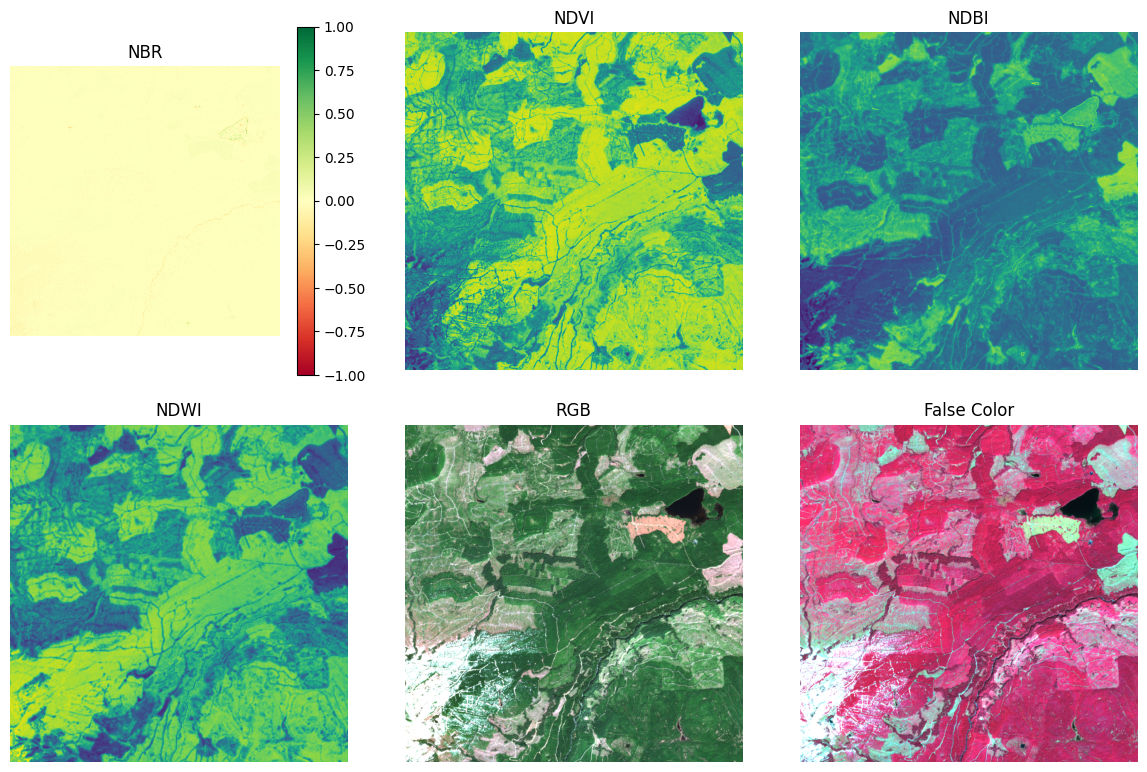

In [57]:
filepath = '../prepared_dataset/image_directory_20180514_9'

display_transformed_images(filepath, percentile=95)

In [66]:
save_transformed_images(filepath, percentile=95)